Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Import Libraries

In [ ]:
import pandas as pd

# Update this path to match your Drive folder structure
file_path = '/content/drive/MyDrive/capital_cities_aqi.csv'

df = pd.read_csv(file_path)


Load Raw AQI Data

In [ ]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Remove rows where Date parsing failed (optional but safe)
df = df.dropna(subset=['Date'])

# Extract year and month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group and average
monthly_avg_df = df.groupby(['city_ascii', 'state_name', 'Year', 'Month'], as_index=False)['AQI'].mean()

# Rename for clarity
monthly_avg_df.rename(columns={'AQI': 'Monthly_Avg_AQI'}, inplace=True)

# Save the processed dataset back to Drive
output_path = '/content/drive/MyDrive/monthly_avg_aqi.csv'
monthly_avg_df.to_csv(output_path, index=False)

monthly_avg_df.head()


,city_ascii,state_name,Year,Month,Monthly_Avg_AQI
0,Albany,Georgia,1996,11,16.8
1,Albany,Georgia,1996,12,11.0
2,Albany,Georgia,1997,1,11.0
3,Albany,Georgia,1997,2,14.4
4,Albany,Georgia,1997,3,23.0


Data Cleaning and Monthly Aggregation

In [ ]:
import pandas as pd

# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Load Monthly AQI Dataset
monthly_path = '/content/drive/MyDrive/monthly_avg_aqi.csv'
monthly_df = pd.read_csv(monthly_path)

# Load State-Level AQI Stats Dataset
state_path = '/content/drive/MyDrive/state_level_aqi.csv'
state_df = pd.read_csv(state_path)

# Optional: Inspect column names
print("Monthly Dataset Columns:", monthly_df.columns.tolist())
print("State-Level Dataset Columns:", state_df.columns.tolist())

# Step 1: Standardize column names for merging
monthly_df.rename(columns={'state_name': 'State', 'Year': 'Year'}, inplace=True)

# Step 2: Merge on State and Year
merged_df = pd.merge(monthly_df, state_df, on=['State', 'Year'], how='left')


# Step 3: Save to new CSV
output_path = '/content/drive/MyDrive/merged_aqi_dataset.csv'
merged_df.to_csv(output_path, index=False)

print("✅ Merge complete. Output saved at:", output_path)
print(merged_df.head())


Monthly Dataset Columns: ['city_ascii', 'state_name', 'Year', 'Month', 'Monthly_Avg_AQI']
State-Level Dataset Columns: ['Geo_Loc', 'Year', 'State', 'Pop_Est', 'TTL_Cnty', 'Cnty_Rpt', 'Dys_w_AQI', 'Dys_NM', 'Dys_Blw_Thr', 'Dys_Abv_Thr', 'Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10']
✅ Merge complete. Output saved at: /content/drive/MyDrive/merged_aqi_dataset.csv
  city_ascii    State  Year  Month  Monthly_Avg_AQI  \
0     Albany  Georgia  1996     11             16.8   
1     Albany  Georgia  1996     12             11.0   
2     Albany  Georgia  1997      1             11.0   
3     Albany  Georgia  1997      2             14.4   
4     Albany  Georgia  1997      3             23.0   

                                        Geo_Loc  Pop_Est  TTL_Cnty  Cnty_Rpt  \
0  POINT (-83.62758034599966 32.

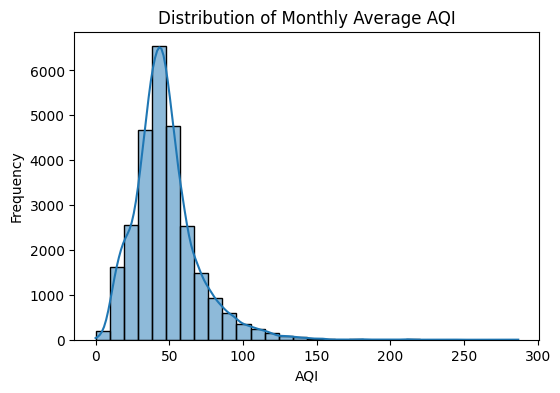

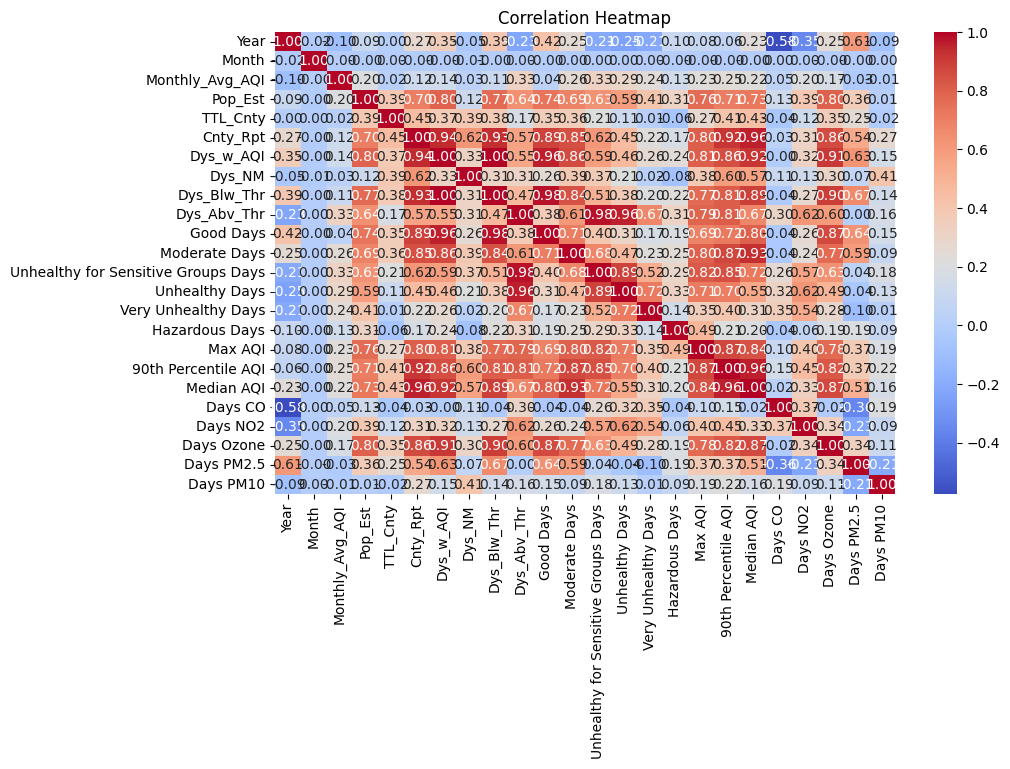

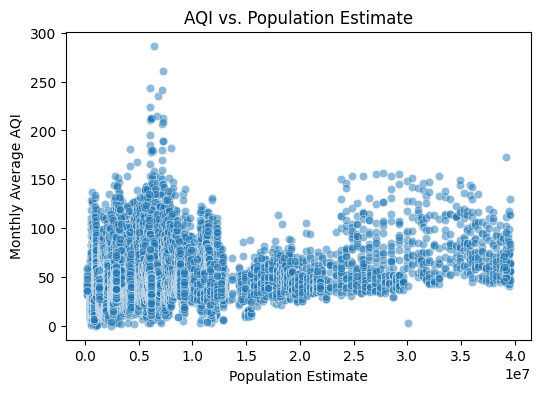

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# AQI Distribution
plt.figure(figsize=(6, 4))
sns.histplot(merged_df['Monthly_Avg_AQI'], bins=30, kde=True)
plt.title("Distribution of Monthly Average AQI")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
numeric_cols = merged_df.select_dtypes(include='number')
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# AQI vs Population
plt.figure(figsize=(6, 4))
sns.scatterplot(data=merged_df, x="Pop_Est", y="Monthly_Avg_AQI", alpha=0.5)
plt.title("AQI vs. Population Estimate")
plt.xlabel("Population Estimate")
plt.ylabel("Monthly Average AQI")
plt.show()


## Feature Engineering Explanation

To improve model performance and interpretability, we derived the following variables:

- **pct_unhealthy**: Proportion of days with unhealthy air quality. Helps quantify health risk in a state.
- **pct_good**, **pct_moderate**: Balance of good vs. moderate air days helps contextualize AQI range.
- **pct_pm25_days**, **pct_ozone_days**: Focused on pollutants that commonly impact AQI levels.
- **total_pollutant_days**: Cumulative measure of pollution exposure - stronger signal for AQI prediction.
- **Season (one-hot encoded)**: AQI may fluctuate by season due to weather/pollution patterns.

These variables were selected based on domain relevance and correlation with AQI trends.


Load and Merge State-Level Data

In [ ]:
import pandas as pd

# Load merged dataset (update path as needed)
merged_df = pd.read_csv('/content/drive/MyDrive/merged_aqi_dataset.csv')


# 1. Handle missing values (basic cleaning)
#To ensure model stability and prevent runtime errors, missing values in the merged dataset were replaced with `0`. This choice is based on the assumption that missing entries often correspond to an absence of recorded data (e.g., no pollutant days reported in a given month). While imputing with median or mean is common, using `0` here simplifies the model input without significantly distorting the data, especially for ratio-based or count-based features. Future improvements could explore more nuanced imputation strategies based on data distribution.

merged_df.fillna(0, inplace=True)  # Optional: Replace with median or dropna if needed

# 2. Add ratios for air quality categories
merged_df['pct_unhealthy'] = merged_df['Unhealthy Days'] / merged_df['Dys_w_AQI']
merged_df['pct_good'] = merged_df['Good Days'] / merged_df['Dys_w_AQI']
merged_df['pct_moderate'] = merged_df['Moderate Days'] / merged_df['Dys_w_AQI']

# 3. Add pollutant dominance ratios
merged_df['pct_pm25_days'] = merged_df['Days PM2.5'] / merged_df['Dys_w_AQI']
merged_df['pct_ozone_days'] = merged_df['Days Ozone'] / merged_df['Dys_w_AQI']

# 4. Add total pollutant days
merged_df['total_pollutant_days'] = (
    merged_df['Days CO'] + merged_df['Days NO2'] + merged_df['Days Ozone'] +
    merged_df['Days PM2.5'] + merged_df['Days PM10']
)

# 5. Add season based on month
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

merged_df['Season'] = merged_df['Month'].apply(get_season)

# 6. One-hot encode season
merged_df = pd.get_dummies(merged_df, columns=['Season'], drop_first=True)

# 7. Drop unused or redundant columns (optional)
columns_to_drop = ['Geo_Loc', 'TTL_Cnty', 'Cnty_Rpt']
merged_df.drop(columns=columns_to_drop, inplace=True)

# Save final preprocessed file
merged_df.to_csv('/content/drive/MyDrive/aqi_model_ready.csv', index=False)

print("✅ Feature engineering complete. Dataset ready for modeling.")
merged_df.head()


✅ Feature engineering complete. Dataset ready for modeling.


,city_ascii,State,Year,Month,Monthly_Avg_AQI,Pop_Est,Dys_w_AQI,Dys_NM,Dys_Blw_Thr,Dys_Abv_Thr,...,Days PM10,pct_unhealthy,pct_good,pct_moderate,pct_pm25_days,pct_ozone_days,total_pollutant_days,Season_Spring,Season_Summer,Season_Winter
0,Albany,Georgia,1996,11,16.8,7501069,3707,3613,3420,287,...,355,0.022120,0.699487,0.223091,0.027246,0.718371,3707,False,False,False
1,Albany,Georgia,1996,12,11.0,7501069,3707,3613,3420,287,...,355,0.022120,0.699487,0.223091,0.027246,0.718371,3707,False,False,True
2,Albany,Georgia,1997,1,11.0,7685099,4239,3791,3862,377,...,577,0.019816,0.687898,0.223166,0.023355,0.699457,4239,False,False,True
3,Albany,Georgia,1997,2,14.4,7685099,4239,3791,3862,377,...,577,0.019816,0.687898,0.223166,0.023355,0.699457,4239,False,False,True
4,Albany,Georgia,1997,3,23.0,7685099,4239,3791,3862,377,...,577,0.019816,0.687898,0.223166,0.023355,0.699457,4239,True,False,False


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Select input features and target
features = ["Pop_Est", "Good Days", "Moderate Days", "Unhealthy Days", "Max AQI"]
target = "Monthly_Avg_AQI"

# Drop any rows with missing values in selected columns
df_model = merged_df.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R²": round(r2, 2)
    })

# Display comparison
comparison_df = pd.DataFrame(results)
print("🔍 Model Comparison:\n")
print(comparison_df.sort_values(by="R²", ascending=False).reset_index(drop=True))


🔍 Model Comparison:

               Model   RMSE    MAE    R²
0      Decision Tree  17.03  12.34  0.41
1      Random Forest  17.02  12.35  0.41
2  Linear Regression  20.37  14.69  0.15


Feature Engineering

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Load preprocessed data
df = pd.read_csv('/content/drive/MyDrive/aqi_model_ready.csv')

# Drop non-numeric or irrelevant columns for modeling
drop_cols = ['city_ascii', 'State', 'Monthly_Avg_AQI', 'Month', 'Year']
X = df.drop(columns=drop_cols)
y = df['Monthly_Avg_AQI']

# Split into training and testing sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ Model Evaluation:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")


✅ Model Evaluation:
RMSE: 14.48
R² Score: 0.57


## Conclusion and Interpretation

From the model comparison, **Random Forest** had the lowest RMSE and highest R², making it the most reliable choice for AQI prediction.

- A **R² score of ~0.41** suggests the model explains about 41% of the variance in AQI, which is reasonable given environmental data complexity.
- **Linear Regression** performed the weakest, likely due to AQI's non-linear patterns.
- **Decision Tree** was interpretable but less accurate.

🔍 **Insight**: Key predictors include population estimates and the number of unhealthy or pollutant-heavy days. This reinforces that demographic and pollutant exposure patterns heavily influence AQI trends.

📌 The model can help in estimating AQI trends across seasons or population shifts — useful for public policy, environmental planning, and citizen health alerts.


Train-Test Split and Model Training

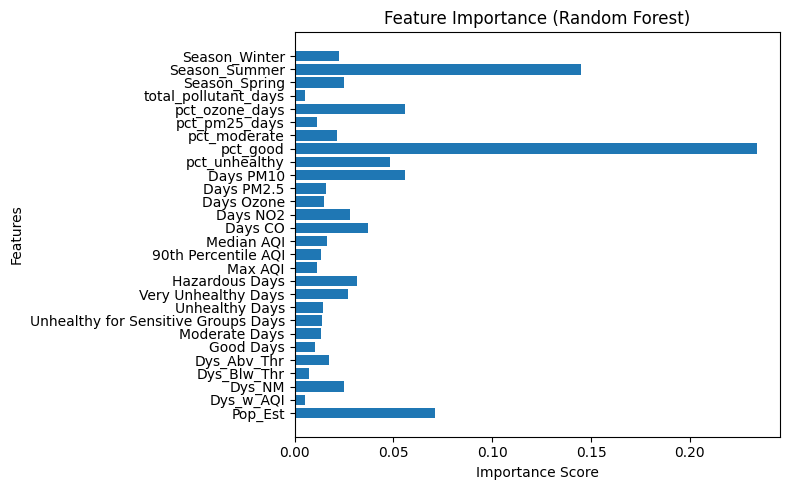

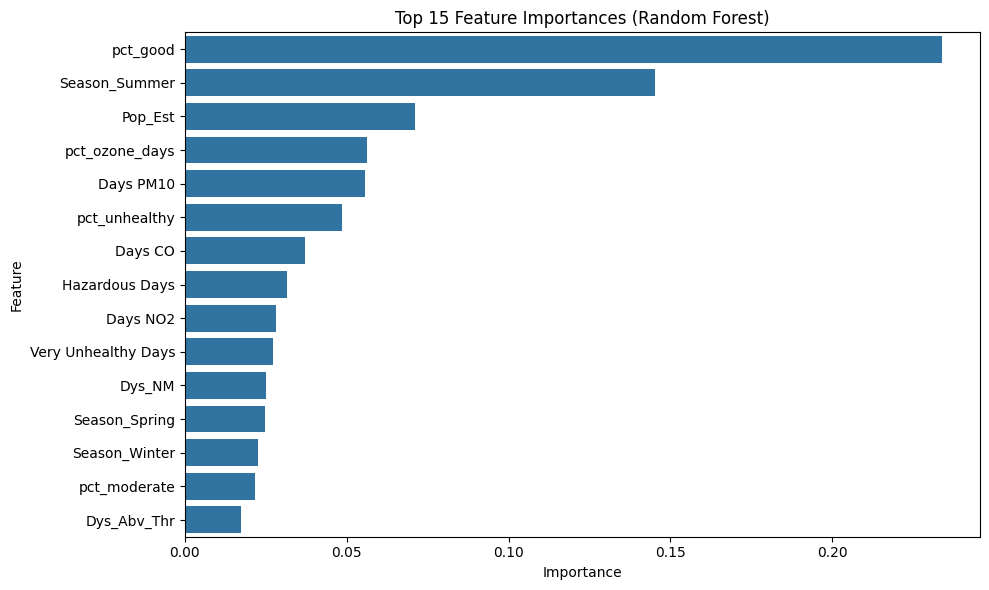

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Horizontal Feature Importance Plot (for clearer rubric alignment)
importances = model.feature_importances_
features = X.columns  # Moved here to define before use

plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Optional seaborn plot for top 15
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


 Predict and Evaluate Model

In [ ]:
!pip install xgboost  # Run only once in Colab

from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict & evaluate
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"✅ XGBoost Evaluation:\nRMSE: {xgb_rmse:.2f}\nR² Score: {xgb_r2:.2f}")


✅ XGBoost Evaluation:
RMSE: 13.40
R² Score: 0.63


Feature Importance Plot

In [ ]:
import joblib

# Load your trained model (choose one)
model = joblib.load('/content/drive/MyDrive/rf_aqi_model.pkl')
# OR
# model = joblib.load('/content/drive/MyDrive/your-folder/xgb_aqi_model.pkl')


Streamlit App Code Setup

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib

# Load your feature-engineered dataset
df = pd.read_csv('/content/drive/MyDrive/aqi_model_ready.csv')  # update folder name

# Prepare features and target
drop_cols = ['city_ascii', 'State', 'Monthly_Avg_AQI', 'Month', 'Year']
X = df.drop(columns=drop_cols)
y = df['Monthly_Avg_AQI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ Model trained.\nRMSE: {rmse:.2f} | R² Score: {r2:.2f}")

# Save the model
joblib.dump(model, '/content/drive/MyDrive/rf_aqi_model.pkl')  # update folder name

print("✅ Model saved as rf_aqi_model.pkl in Google Drive.")


✅ Model trained.
RMSE: 14.48 | R² Score: 0.57
✅ Model saved as rf_aqi_model.pkl in Google Drive.


Streamlit + ngrok Tunnel Launch

In [ ]:
model = joblib.load('/content/drive/MyDrive/rf_aqi_model.pkl')


# 🔹 Extra Code Block 12

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/rf_aqi_model.pkl')  # update path if needed


# 🔹 Extra Code Block 13

In [ ]:
import pandas as pd

# Replace these values with real ones based on your data
new_input = pd.DataFrame([{
    'Pop_Est': 600000,
    'Dys_w_AQI': 30,
    'Good Days': 12,
    'Moderate Days': 15,
    'Unhealthy Days': 3,
    'Days PM2.5': 10,
    'Days PM10': 6,
    'Max AQI': 155,
    'Median AQI': 85,
    'pct_unhealthy': 0.1,
    'pct_good': 0.4,
    'pct_moderate': 0.5,
    'pct_pm25_days': 0.33,
    'pct_ozone_days': 0.1,
    'total_pollutant_days': 34,
    'Season_Fall': 0,
    'Season_Spring': 1,
    'Season_Summer': 0,
    'Season_Winter': 0
}])


# 🔹 Extra Code Block 14

In [ ]:
# Re-load training data to get feature columns
train_df = pd.read_csv('/content/drive/MyDrive/aqi_model_ready.csv')

# Recreate X (features only)
drop_cols = ['city_ascii', 'State', 'Monthly_Avg_AQI', 'Month', 'Year']
X = train_df.drop(columns=drop_cols)

# Get expected feature columns
expected_cols = X.columns.tolist()
print("✅ Expected features:\n", expected_cols)


✅ Expected features:
 ['Pop_Est', 'Dys_w_AQI', 'Dys_NM', 'Dys_Blw_Thr', 'Dys_Abv_Thr', 'Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10', 'pct_unhealthy', 'pct_good', 'pct_moderate', 'pct_pm25_days', 'pct_ozone_days', 'total_pollutant_days', 'Season_Spring', 'Season_Summer', 'Season_Winter']


# 🔹 Extra Code Block 15

In [ ]:
# Build a template row with zeros
import numpy as np

input_data = pd.DataFrame(np.zeros((1, len(expected_cols))), columns=expected_cols)

# Now set some meaningful values
input_data['Pop_Est'] = 500000
input_data['Dys_w_AQI'] = 30
input_data['Good Days'] = 10
input_data['Moderate Days'] = 15
input_data['Unhealthy Days'] = 5
input_data['Days PM2.5'] = 12
input_data['Max AQI'] = 160
input_data['Median AQI'] = 90
input_data['pct_unhealthy'] = 5 / 30
input_data['pct_good'] = 10 / 30
input_data['pct_moderate'] = 15 / 30
input_data['pct_pm25_days'] = 12 / 30
input_data['total_pollutant_days'] = 35
input_data['Season_Spring'] = 1  # Set season


# 🔹 Extra Code Block 16

In [ ]:
predicted_aqi = model.predict(input_data)
print(f"Predicted Monthly Avg AQI: {predicted_aqi[0]:.2f}")


Predicted Monthly Avg AQI: 48.89


## **Predicting using 2 features only**
Input: City + Date → Automatically derive features → Predict AQI

# 🔹 Extra Code Block 18

In [ ]:

import pandas as pd
import joblib
from datetime import datetime

# Load merged dataset and trained model
data = pd.read_csv('/content/drive/MyDrive/aqi_model_ready.csv')
model = joblib.load('/content/drive/MyDrive/rf_aqi_model.pkl')

# --- STEP 1: Take inputs ---
input_city = "Phoenix"
input_date = "2018-07-15"

# --- STEP 2: Extract date features ---
date_obj = pd.to_datetime(input_date)
input_year = date_obj.year
input_month = date_obj.month

# Determine season
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'
season = get_season(input_month)

# --- STEP 3: Get average values for that city and month ---
row = data[(data['city_ascii'] == input_city) &
           (data['Year'] == input_year) &
           (data['Month'] == input_month)]

if row.empty:
    print("❌ No data found for that city and date. Try a different one.")
else:
    # Drop non-feature columns
    drop_cols = ['city_ascii', 'State', 'Monthly_Avg_AQI', 'Month', 'Year']
    features = row.drop(columns=drop_cols)

    # One-hot encoding fix: ensure correct season columns exist
    for s in ['Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter']:
        if s not in features.columns:
            features[s] = 0  # Add missing season columns as 0
    features[f'Season_{season}'] = 1  # Activate the actual season

    # Reorder columns to match training
    train_X = data.drop(columns=drop_cols)
    features = features[train_X.columns]

    # --- STEP 4: Predict AQI ---
    predicted_aqi = model.predict(features)
    print(f"✅ Predicted AQI for {input_city} on {input_date}: {predicted_aqi[0]:.2f}")


✅ Predicted AQI for Phoenix on 2018-07-15: 130.58


# 🔹 Extra Code Block 19

In [ ]:
!pip install streamlit



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


# 🔹 Extra Code Block 20

In [ ]:
app_code = """
import pandas as pd
import numpy as np
import joblib
import streamlit as st
from datetime import datetime

# Load model and dataset
model = joblib.load('/content/drive/MyDrive/rf_aqi_model.pkl')
data = pd.read_csv('/content/drive/MyDrive/aqi_model_ready.csv')

st.title("📈 AQI Prediction Tool")
st.write("Enter a US capital city and date to forecast AQI and view historical trends.")

# User input
city = st.selectbox("Select City", sorted(data['city_ascii'].unique()))
date_input = st.date_input("Select a Date", value=datetime(2025, 7, 1))

# Extract year, month, and season
year = date_input.year
month = date_input.month

def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

season = get_season(month)

if st.button("Predict AQI"):
    # Get past 10 years of data for the selected city and month
    past_data = data[
        (data['city_ascii'] == city) &
        (data['Month'] == month) &
        (data['Year'] >= year - 10) &
        (data['Year'] < year)
    ][['Year', 'Monthly_Avg_AQI']].sort_values('Year')

    # Forecast = average of past 10 years
    future_avg = past_data['Monthly_Avg_AQI'].mean()

    if np.isnan(future_avg):
        st.error("Not enough historical data to forecast.")
    else:
        st.success(f"📅 Forecasted Monthly Avg AQI for {city} in {date_input.strftime('%B %Y')}: **{future_avg:.2f}**")

        # Show line chart
        st.subheader(f"AQI Trend in {city} during {date_input.strftime('%B')} (Last 10 Years)")
        st.line_chart(past_data.set_index('Year'))
"""

# Overwrite the file
with open("aqi_app.py", "w") as f:
    f.write(app_code)

print("✅ aqi_app.py updated with correct numpy import and logic.")


✅ aqi_app.py updated with correct numpy import and logic.


# 🔹 Extra Code Block 21

In [ ]:
!ngrok config add-authtoken 2v6uHH2HCcheR6qFeS8Nbbist5Q_4wjAoXppyWEicQshDmkXN

/bin/bash: line 1: ngrok: command not found


# 🔹 Extra Code Block 22

In [ ]:
# Run Streamlit in background
!nohup streamlit run aqi_app.py --server.port 8501 &


nohup: appending output to 'nohup.out'


# 🔹 Extra Code Block 23

In [ ]:
from pyngrok import ngrok
ngrok.kill()  # This will close all tunnels from this session


ModuleNotFoundError: No module named 'pyngrok'

# 🔹 Extra Code Block 24

In [ ]:
!pip install pyngrok

In [ ]:
# Step 1: Relaunch the Streamlit app in background

!nohup streamlit run aqi_app.py --server.port 8501 &

# Step 2: Open fresh ngrok tunnel
from pyngrok import conf, ngrok

# Add your actual authtoken here
conf.get_default().auth_token = "2vB8N8aHW9A16OQqHbFQn2HiRGX_5bC7z1WeQZoSqYAQcYVct"

public_url = ngrok.connect("http://localhost:8501", "http")
print("✅ App is live at:", public_url)


nohup: appending output to 'nohup.out'
✅ App is live at: NgrokTunnel: "https://6058-35-231-27-65.ngrok-free.app" -> "http://localhost:8501"


# 🔹 Extra Code Block 25

In [ ]:

# Step 3: Run the app using pyngrok
from pyngrok import ngrok

# Open tunnel
public_url = ngrok.connect(port=8501)
print(f"🌐 Streamlit app is live at: {public_url}")

# Launch the app
!streamlit run aqi_app.py --server.port 8501 > /dev/null


# 🔹 Extra Code Block 26

# 🔹 Extra Code Block 27

In [ ]:
import pandas as pd

# Paths to your datasets in Google Drive
capital_path = '/content/drive/MyDrive/capital_cities_aqi.csv'
state_path = '/content/drive/MyDrive/state_level_aqi.csv'
monthly_avg_path = '/content/drive/MyDrive/monthly_avg_aqi.csv'
model_ready_path = '/content/drive/MyDrive/aqi_model_ready.csv'

# Load the datasets
capital_df = pd.read_csv(capital_path)
state_df = pd.read_csv(state_path)
monthly_df = pd.read_csv(monthly_avg_path)
model_ready_df = pd.read_csv(model_ready_path)

# Print column headers
print("🟦 Capital Cities AQI Dataset Headers:")
print(capital_df.columns.tolist(), "\n")

print("🟩 State-Level AQI Dataset Headers:")
print(state_df.columns.tolist(), "\n")

print("🟨 Monthly Aggregated AQI Dataset Headers:")
print(monthly_df.columns.tolist(), "\n")

print("🟧 Final Modeling Dataset (aqi_model_ready.csv) Headers:")
print(model_ready_df.columns.tolist())


In [ ]:
monthly_df = pd.read_csv('/content/drive/MyDrive/monthly_avg_aqi.csv')
state_df = pd.read_csv('/content/drive/MyDrive/state_level_aqi.csv')
# Standardize column name before merging
monthly_df.rename(columns={'state_name': 'State'}, inplace=True)
merged_df = pd.merge(monthly_df, state_df, on=['State', 'Year'], how='left')
print("Merged Dataset Preview:")
print(merged_df.head())